## Data preparation

In [29]:
from azure.storage.blob import ContainerClient
from collections import defaultdict
import io
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import random
import re
from itertools import chain
import numpy as np

from IPython.display import HTML
import matplotlib.animation as animation

<br>
* Access data from blob storage:

In [30]:
FACTS_SAS_TOKEN = "se=2020-10-15&sp=rl&spr=https&sv=2018-11-09&sr=c&sig=A9/0jGPBe/i1b8qHkrplGg17vokAu%2Bih1izG0tFSl4U%3D"
FACTS_CONTAINER = "eleven-2020-facts"
WORKSPACE_SAS_TOKEN = "se=2020-10-15&sp=rwdl&spr=https&sv=2018-11-09&sr=c&sig=l8lwqMq%2BPoSVfJjGf5mAQ8uIHHULKU65xb7QhOtkzdg%3D"
WORKSPACE_CONTAINER = "eleven-2020-workspace-group6"

In [31]:
ACCOUNT_URL = "https://hecdf.blob.core.windows.net"

facts_blob_service = ContainerClient(account_url=ACCOUNT_URL,
                                     container_name=FACTS_CONTAINER,
                                     credential=FACTS_SAS_TOKEN)
workspace_blob_service = ContainerClient(account_url=ACCOUNT_URL,
                                         container_name=WORKSPACE_CONTAINER,
                                         credential=WORKSPACE_SAS_TOKEN)

In [32]:
blobs = list(facts_blob_service.list_blobs())
names = [blob.name for blob in blobs]

In [16]:
hierarchy_dict = {'root': defaultdict(int)}

for name in names:
    directory = 'root'
    directory_dict = hierarchy_dict['root']
    name_split = name.split('/')
    for depth, path_chunk in enumerate(name_split, 1):
        if depth == len(name_split):
            directory_dict['.' + path_chunk.split('.')[-1]] += 1
        else:
            if path_chunk not in directory_dict:
                directory_dict[path_chunk] = defaultdict(int)
            directory_dict = directory_dict[path_chunk]

In [17]:
def print_hierarchy(directory_name, directory_dict, depth):
    indent = '\t' * depth
    print(f"{indent}∟ {directory_name}")
    for element in sorted(directory_dict):
        if element.startswith('.'):
            print(f"{indent} {element} : {directory_dict[element]} files")
        else:
            print_hierarchy(element, directory_dict[element], depth + 1)

In [18]:
print_hierarchy('root', hierarchy_dict['root'], 0)

∟ root
 .DS_Store : 1 files
	∟ Detection_Train_Set
	 .DS_Store : 1 files
		∟ Detection_Train_Set_Img
		 .jpg : 1582 files
		∟ Detection_Train_Set_Json
		 .json : 1582 files
	∟ Detection_Train_Set_Bis
		∟ ann
		 .json : 999 files
		∟ img
		 .jpg : 999 files


<br>
* Get more info on images and classes:

In [11]:
train_set_names_dict = dict()
train_set_img_path = 'Detection_Train_Set/Detection_Train_Set_Img/'
train_set_json_path = 'Detection_Train_Set/Detection_Train_Set_Json/'
#train_set_img_path_bis = 'Detection_Train_Set_Bis/img/'
#train_set_json_path_bis = 'Detection_Train_Set_Bis/ann/'

for blob in facts_blob_service.list_blobs():
    if blob.name.startswith(train_set_img_path):
        name = blob.name.split('/')[-1].split('.')[0]
        building_site = '_'.join(name.split('_')[2:-1])
        if building_site not in train_set_names_dict:
            train_set_names_dict[building_site] = list()
        train_set_names_dict[building_site].append(name)

#for blob in facts_blob_service.list_blobs():
#    if blob.name.startswith(train_set_img_path_bis):
#        name = blob.name.split('/')[-1].split('.')[0]
#        print(name)
#        train_set_names_dict['Marseille'].append(name)
        
print('Building sites:')
for building_site in train_set_names_dict:
    print(f"- {building_site:<40} : {len(train_set_names_dict[building_site]):>3} images")
    train_set_names_dict[building_site] = sorted(train_set_names_dict[building_site],
                                                 key=lambda x: int(re.findall('\d+', x)[-1]))

Building sites:
- BioSAV_BIofiltration_18mois              :  97 images
- Devisubox2                               : 294 images
- Marseille                                : 779 images
- Nouveau_campus                           : 260 images
- Roissy                                   : 152 images


In [79]:
class_title_set = set()

for train_sample in chain.from_iterable(train_set_names_dict.values()):
    train_sample_json_path = train_set_json_path + train_sample + '.jpg.json'
    img_json = json.load(io.BytesIO(facts_blob_service.get_blob_client(train_sample_json_path).download_blob().readall()))
    for object_dict in img_json['objects']:
        class_title_set.add(object_dict['classTitle'])

print('Classes:')
print('\n'.join(class_title_set))
color_map = dict(zip(class_title_set, ['r', 'g', 'b', 'y']))

Classes:
Mixer_truck
Vertical_formwork
People
Concrete_pump_hose


<br>
* Download images and labels locally:

In [35]:
# Method 1
for blob in tqdm(facts_blob_service.list_blobs(), total=len(list(facts_blob_service.list_blobs()))):
    if not blob.name.endswith('DS_Store') and not blob.name.endswith('Bis') and not blob.name.startswith('Analytics'):
        with open(os.path.join('data_eleven', blob.name), 'wb') as fp:
            fp.write(facts_blob_service.get_blob_client(blob).download_blob().readall())

FileNotFoundError: [Errno 2] No such file or directory: 'data_eleven/Detection_Train_Set/Detection_Train_Set_Img/Batch2__BioSAV_BIofiltration_18mois_05frame3049.jpg'

In [223]:
# Method 2 (preferred here)

import os
import imageio
from tqdm.notebook import tqdm
try:
    os.makedirs("../chronsite_images_full")
    os.makedirs("../chronsite_images_full/images")
    os.makedirs("../chronsite_images_full/labels")
except:
    pass
for site in tqdm(train_set_names_dict.keys(), leave=False):
    for sample_path in train_set_names_dict[site]:
        train_sample_img_path = train_set_img_path + sample_path + '.jpg'
        train_sample_json_path = train_set_json_path + sample_path + '.jpg.json'
        
        img = plt.imread(io.BytesIO(facts_blob_service.get_blob_client(train_sample_img_path).download_blob().readall()), format='jpg')
        img_json = json.load(io.BytesIO(facts_blob_service.get_blob_client(train_sample_json_path).download_blob().readall()))
                
        imageio.imwrite(os.path.join("../chronsite_images", "images", train_sample_img_path.split('/')[-1]), img)
        with open(os.path.join("../chronsite_images", "labels", train_sample_json_path.split('/')[-1].split('.')[0] + '.txt'), "w") as text_file:
            text_file.write(str(img_json))

* Display examples of images and labels

In [10]:
def draw_box(ax, bounding_boxes):
    for shape_type, class_title, points in bounding_boxes:
        if shape_type == 'rectangle':
            bottom_left = points[0]
            width = points[1][0] - points[0][0]
            height = points[1][1] - points[0][1]
            rect = patches.Rectangle(bottom_left, width, height, linewidth=2,
                                     edgecolor=color_map[class_title], facecolor='none')
            ax.add_patch(rect)
        else:
            polygon = patches.Polygon(points, linewidth=2,
                                      edgecolor=color_map[class_title], facecolor='none')
            ax.add_patch(polygon)


def generate_sample(building_site):
    train_sample = random.choice(train_set_names_dict[building_site])
    train_sample_img_path = train_set_img_path + train_sample + '.jpg'
    train_sample_json_path = train_set_json_path + train_sample + '.jpg.json'

    img = plt.imread(io.BytesIO(facts_blob_service.get_blob_client(train_sample_img_path).download_blob().readall()), format='jpg')
    img_json = json.load(io.BytesIO(facts_blob_service.get_blob_client(train_sample_json_path).download_blob().readall()))

    bounding_boxes = list()
    for object_dict in img_json['objects']:
        bounding_boxes.append((object_dict['geometryType'],
                               object_dict['classTitle'],
                               object_dict['points']['exterior']))

    fig, ax = plt.subplots(1, figsize=(12, 12))
    draw_box(ax, bounding_boxes)
    ax.imshow(img)

    plt.show()

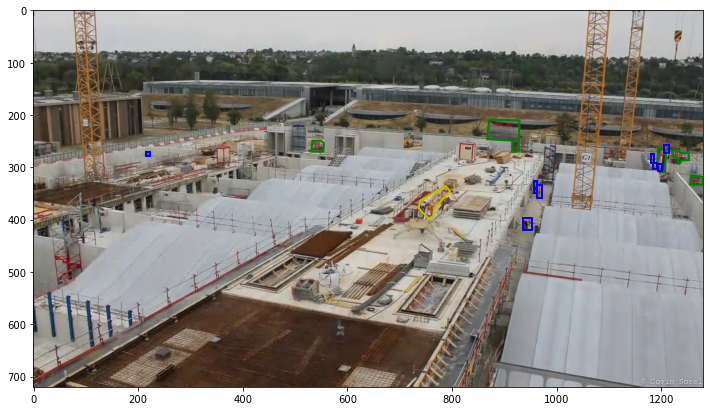

In [11]:
generate_sample(list(train_set_names_dict)[0])

In [13]:
def animate(building_site, boxes=False, steps=60):
    fig = plt.figure(figsize=(12, 6))
    ims = []
    for i in tqdm(range(min(steps, len(train_set_names_dict[building_site])))):
        train_sample = train_set_names_dict[building_site][i]
        train_sample_img_path = train_set_img_path + train_sample + '.jpg'
        train_sample_json_path = train_set_json_path + train_sample + '.jpg.json'

        img = plt.imread(io.BytesIO(facts_blob_service.get_blob_client(train_sample_img_path).download_blob().readall()), format='jpg')
        im = plt.imshow(img, animated=True)
        if boxes:
            img_json = json.load(io.BytesIO(facts_blob_service.get_blob_client(train_sample_json_path).download_blob().readall()))

            bounding_boxes = list()
            for object_dict in img_json['objects']:
                bounding_boxes.append((object_dict['geometryType'],
                                       object_dict['classTitle'],
                                       object_dict['points']['exterior']))

            draw_box(im, bounding_boxes)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True,
                                    repeat_delay=1000)

    return HTML(ani.to_jshtml())

AttributeError: 'AxesImage' object has no attribute 'add_patch'

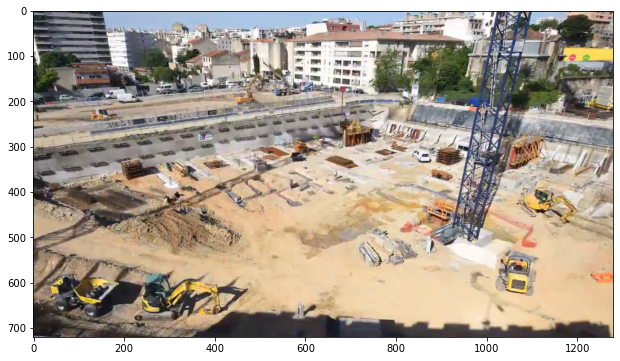

In [14]:
animate('Marseille', boxes=True, steps=10)

* Create masks based on polygon labels

In [8]:
import glob
import os
image_paths = glob.glob('../chronsite_images/images/*.jpg') # list image names
image_paths.sort()

In [9]:
label_paths = glob.glob('../chronsite_images/labels/*.txt')
label_paths.sort()

In [10]:
os.path.splitext(os.path.basename(image_paths[0]))[0]

'Batch2__BioSAV_BIofiltration_18mois_05frame3049'

In [13]:
# compute min polygon size

formworks_list = []
pumps_list = []
for idx, image_path in enumerate(image_paths):
    
    # Extract pixel coordinates of polygons corresponding to the image
    with open(label_paths[idx], "r") as image_label:
    
        # read labels
        import ast
        label_dict = ast.literal_eval(image_label.read())
        bounding_boxes = list()
        for object_dict in label_dict['objects']:
            bounding_boxes.append((object_dict['geometryType'],
                                   object_dict['classTitle'],
                                   object_dict['points']['exterior']))
        
        # select only polygon coordinates, for each of the 2 classes
        formworks = []
        pumps = []
        for geom in bounding_boxes:
            if geom[0] == 'polygon' and geom[1] == 'Vertical_formwork':
                coords = [tuple(x) for x in geom[2]]
                formworks.append(coords)
            elif geom[0] == 'polygon' and geom[1] == 'Concrete_pump_hose':
                coords = [tuple(x) for x in geom[2]]
                pumps.append(coords)
    
    formworks_list.extend(formworks)
    pumps_list.extend(pumps)

In [28]:
from shapely.geometry import Polygon
pumps_list2 = [Polygon(pump).area for pump in pumps_list]
min(pumps_list2)

156.0

In [278]:
for idx, image_path in enumerate(image_paths):
    
    # Extract pixel coordinates of polygons corresponding to the image
    with open(label_paths[idx], "r") as image_label:
    
        # read labels
        import ast
        label_dict = ast.literal_eval(image_label.read())
        bounding_boxes = list()
        for object_dict in label_dict['objects']:
            bounding_boxes.append((object_dict['geometryType'],
                                   object_dict['classTitle'],
                                   object_dict['points']['exterior']))
        
        # select only polygon coordinates, for each of the 2 classes
        formworks = []
        pumps = []
        for geom in bounding_boxes:
            if geom[0] == 'polygon' and geom[1] == 'Vertical_formwork':
                coords = [tuple(x) for x in geom[2]]
                formworks.append(coords)
            elif geom[0] == 'polygon' and geom[1] == 'Concrete_pump_hose':
                coords = [tuple(x) for x in geom[2]]
                pumps.append(coords)
        
    # Read image
    import skimage.io as io
    image = io.imread(image_path)    
    width = image.shape[1]
    height = image.shape[0]
    
    # Create masks (1 mask per class, with several instances in the same mask)
    from PIL import Image, ImageDraw
    from skimage import img_as_ubyte
    masks_formworks = np.zeros((height, width))
    masks_pumps = np.zeros((height, width))
    for i in range(len(formworks)):
        img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
        ImageDraw.Draw(img).polygon(formworks[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
        mask_i = np.array(img)
        masks_formworks += mask_i
    for i in range(len(pumps)):
        img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
        ImageDraw.Draw(img).polygon(pumps[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
        mask_i = np.array(img)
        masks_pumps += mask_i
    
    # Clip masks to binary values and convert to uint8
    masks_formworks = np.clip(masks_formworks, 0, 1)
    masks_pumps = np.clip(masks_pumps, 0, 1)
    masks_formworks = img_as_ubyte(masks_formworks)
    masks_pumps = img_as_ubyte(masks_pumps)

    # Write to disk
    try:
        os.makedirs("../chronsite_images/masks")
    except:
        pass
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    import imageio
    imageio.imwrite('../chronsite_images/masks/{}_{}.png'.format(image_name, 'formworks'), masks_formworks)  
    imageio.imwrite('../chronsite_images/masks/{}_{}.png'.format(image_name, 'pumps'), masks_pumps)

    # print status
    #print('\r{}/{} - {} formworks and {} pumps masked for {}'.format(idx+1, len(image_paths), len(formworks), len(pumps), image_name), end="")
    print(f'\r{idx+1}/{len(image_paths)} - {len(formworks)} formworks and {len(pumps)} pumps masked for {image_name}', end="")

1582/1582 - 0 formworks and 0 pumps masked for Batch2__Roissy_02frame9285frame18905frame3539

<br>
* Other experiments

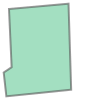

In [169]:
!pip install shapely
from shapely import geometry
polygon = shapely.geometry.Polygon(points)
polygon

In [ ]:
for shape_type, class_title, points in poly:
    if shape_type == 'rectangle':
        bottom_left = tuple(points[0])
        top_right = tuple(points[1])
        width = points[1][0] - points[0][0]
        height = points[1][1] - points[0][1]
        bottom_right = tuple([points[0][1], points[1][0]])
        top_left = tuple([points[0][0], points[1][1]])
        rect = patches.Rectangle(bottom_left, width, height, linewidth=2,
                                 edgecolor=color_map[class_title], facecolor='none')
    else:
        polygon = patches.Polygon(points, linewidth=2,
                                  edgecolor=color_map[class_title], facecolor='none')

In [117]:
coords = [bottom_left, top_right, bottom_right, top_left]
coords

[(581, 441), (589, 450), (441, 589), (581, 450)]

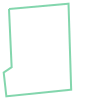

In [176]:
poly_coords = polygon.exterior
poly_coords

In [190]:
points2 = [tuple(x) for x in points]
polygons = points2
polygons

[(628, 516), (673, 520), (675, 455), (626, 450), (624, 468), (630, 472)]

In [207]:
# Create mask

from PIL import Image, ImageDraw
from skimage import img_as_ubyte

width=image_shape[1]
height=image_shape[0]
masks_image = []
for i in range(len(polygons)):
    img = Image.new('L', (width, height), 0) # 'L' = 8-bit pixels, black and white
    ImageDraw.Draw(img).polygon(polygons[i], outline=1, fill=1) # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
    mask_i = np.array(img)
    mask = np.zeros((height, width))
    mask += mask_i
    mask = img_as_ubyte(mask)
    masks_image.append(mask_i)
masks_image = np.asarray(masks_image)

In [208]:
mask.shape

(720, 1280)

In [209]:
masks_image.shape

(21, 720, 1280)

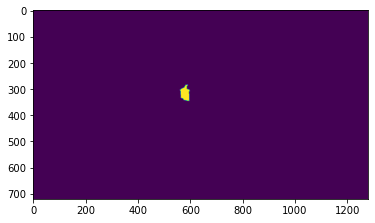

In [215]:
plt.imshow(masks_image[0])

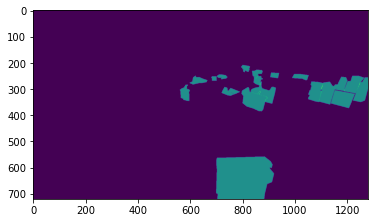

In [219]:
all_masks = sum(masks_image)
plt.imshow(all_masks)

<br>
* Download data locally

In [ ]:
import os
import zipfile
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(path, '..')))
def zipit(dir_list, zip_name):
    zipf = zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED)
    for mdir in dir_list:
        zipdir(mdir, zipf)
    zipf.close()
zipit("eleven/", "archive_chronsite.zip")